In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
from torch.optim import SGD
# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
%matplotlib notebook

# Experiment Lab for ODE

During the training process of our neural network, loads of hyperparameters could change the final result. To assist our investigations on the relationship between the functional approximations and all the hyperparameters that we can adjust in the `solve` function for this NNDE, we introduce this `solver` function to you.
1. Instantiate a solver. (Specify the ODE/PDE system, initial/boundary conditions, problem domain, etc.)
2. Fit the solver (Specify number of epochs to train, callbacks in each epoch, monitor, etc.)
3. Get the solutions and other internal variables.

**This is the recommended way of solving ODEs (and PDEs later). Once you learn to use a Solver, you should stick to this way instead of using a** `solve` **function.**

Now, let's take a look at what we can adjust in this `solver`, they are:

1) Specifying the Training Set and Validation Set
* `size`: the number of $t$s generated for each epoch

* `t_min` and `t_max`: the domain of $t$ from which we want to draw $t$s

* `method`: a string indicating how to generate the $ts$. It should be one of the following: 'uniform', 'equally-spaced', 'equally-spaced-noisy'. If 'uniform', each $t$ will be drawn independently from the uniform distribution $\text{Unif}($`t_min`, `t_max`$)$. If 'equally-spaced', all $t$s generated in the same epoch will form a grid where each $t$ is equally spaced. 'equally-spaced-noisy' is a noisy version of 'equally-spaced' where we add a Gaussian noise $\epsilon \sim \mathcal{N}(0, ($`t_max`-`t_min`)/(4*`size`) $)$
* `max_epochs`: the number of epochs to run

**Here we create an Generator that generates 64 𝑡s drawn from a uniform distribution for every epoch. Then we use it to solve the ODE. In the meantime, for every epoch, we will use another Generator that generates 128 𝑡s that are equally spaced in the domain we want to solve.**

2) Specifying the Neural Network Architecture
* `n_input_units`: Number of units in the input layer, defaults to 1.
* `n_output_units`: Number of units in the input layer, defaults to 1.
* `n_hidden_layers`: Number of units in the input layer, defaults to 1.
* `hidden_units`: Number of units in each input layer, defaults to 32. If you have 3 hidden layers with 32, 64, and 16 neurons respectively, hidden_units should be a tuple (32, 64, 16).
* `actv`: The activation layer constructor after each hidden layer, defaults to `torch.nn.Tanh`.
* `n_batches_train`: Number of batches to train in every epoch, where batch-size equals ``train_generator.size``.Defaults to 1.
* `n_batches_valid`: Number of batches to validate in every epoch, where batch-size equals ``valid_generator.size``. Defaults to 4.

**This claim need to be ahead of the `solver` as the form in `FCNN` function (fully connected neural network) in `networks` class.**

3) Specifying the ODE and Conditions
* `ode`: a function representing the ODE to be solved. It should be a function that maps $(u, t)$ to $F(u, t)$. For example, we are solving $$F(u, t)=\dfrac{du}{dt} + u=0,$$ then `ode` should be `lambda u, t: diff(u, t) + u`, where `diff(u, t)` is the first order derivative of `u` with respect to `t`.

* `condition`: a `neurodiffeq.conditions.BaseCondition` instance representing the initial condition / boundary condition of the ODE. Here we use `neurodiffeq.conditions.IVP(t_0 = 0, u_0 = 1)` to ensure $u(0) = 1$.

4) Specifying the Check Points for Animation Monitor during Training
We may want to see the check the solution and the loss function during solving the problem (training the network). To do this, we need to pass a neurodiffeq.monitors.Monitor1D object to solve. A Monitor1D has the following parameters:

* `t_min` and `t_max`: the region of 𝑡 we want to monitor
* `check_every`: the frequency of visualization. If check_every=100, then the monitor will visualize the solution every 100 epochs.

5) Specifying the Optimizer

We can change the optimization algorithms by passing a `torch.optim.Optimizer` object to `Solver*` classes and `solve*` functions as the `optimizer` argument. 

If you are familiar with PyTorch, you know that to initialize an `Optimizer`, we need to tell it the parameters to optimize. In other words, if we want to use a different optimizer from the default one, we also need to create our own networks. 

Here we create a fully connected network and an `SGD` optimizer to optimize its weights. Then we use them to solve the ODE.

In [14]:
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D
from neurodiffeq.generators import Generator1D

# Example 1: Single ODE

Here we solve a harmonic oscillator:

$$
F(u, t) = \frac{d^2u}{dt^2} + u = 0
$$

for

$$
u(0) = 0.0, \frac{du}{dt}|_{t=0} = 1.0
$$

The analytical solution is 

$$u = \sin(t)$$

We can include higher order derivatives in our ODE with the `order` keyword of `diff`, which is defaulted to 1.

Initial condition on $\dfrac{du}{dt}$ can be specified with the `u_0_prime` keyword of `IVP`. 

<IPython.core.display.Javascript object>


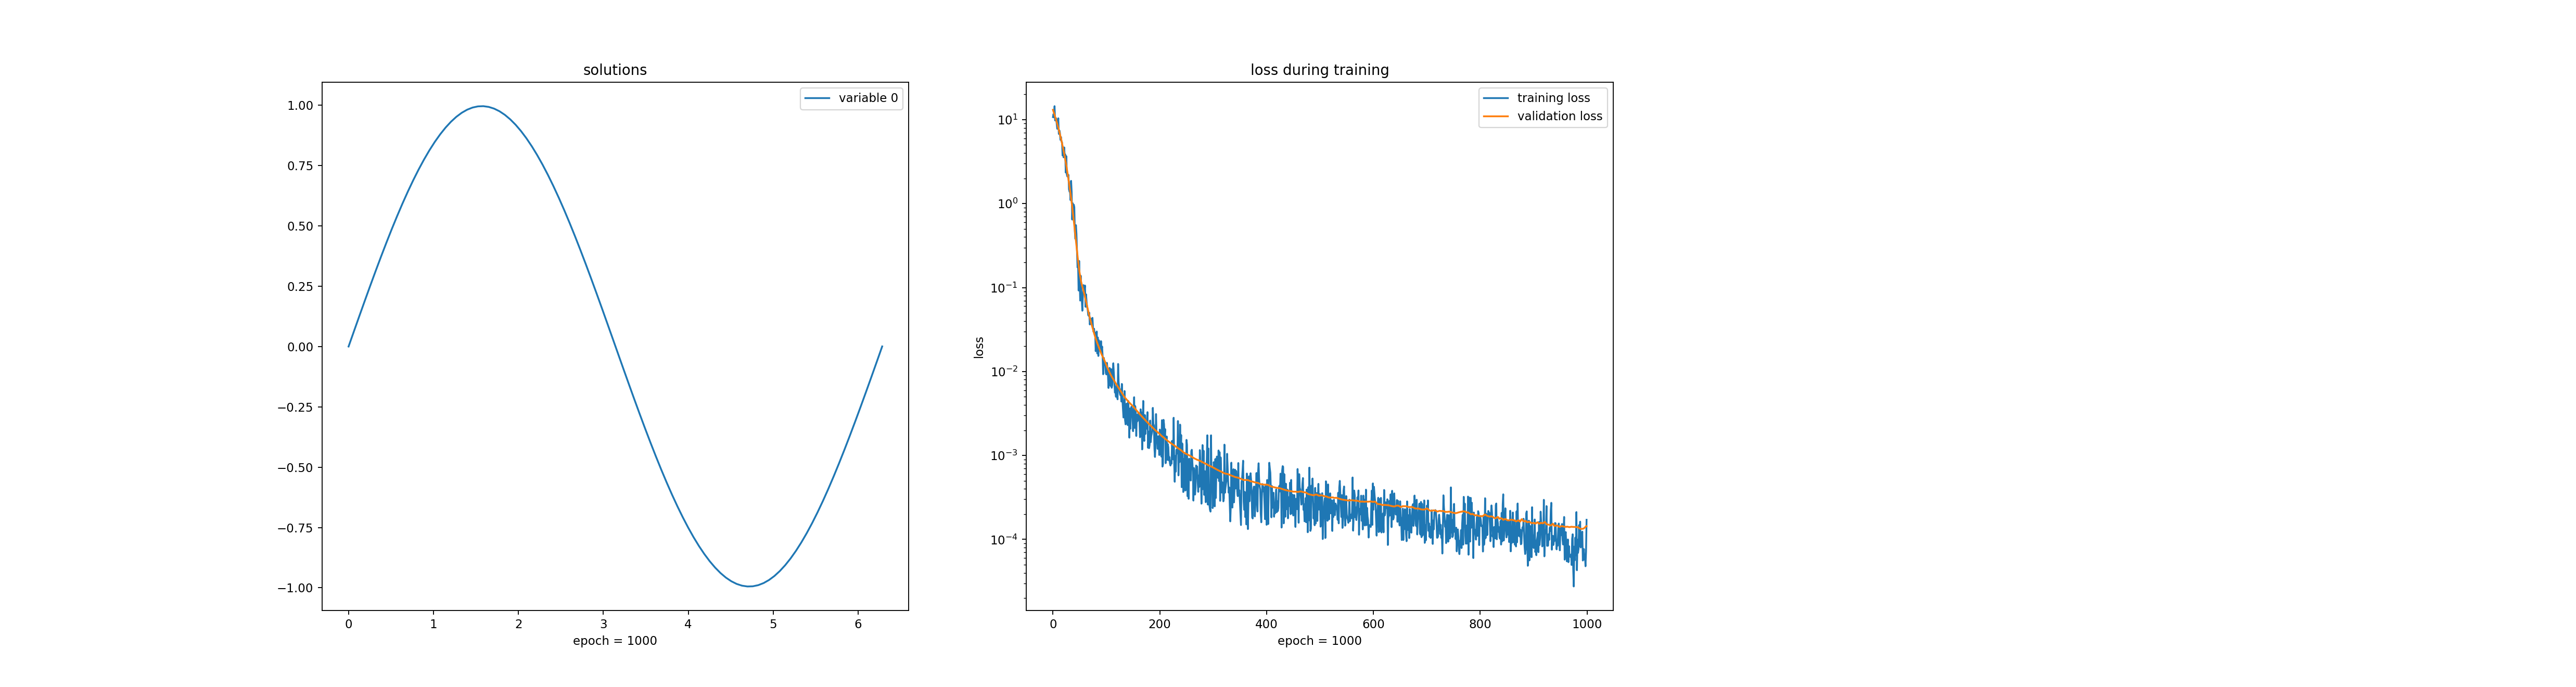

In [15]:
harmonic_oscillator = lambda u, t: [diff(u, t, order=2) + u]
init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)]

# specify the training set and validation set
train_gen = Generator1D(size=64,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = Generator1D(size=128, t_min=0.0, t_max=2*np.pi, method='equally-spaced')

# specify the neural network architecture
nets_ho1 = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64), actv=SinActv)]

solver1 = Solver1D(
    ode_system=harmonic_oscillator, 
    conditions=init_val_ho, 
    t_min=0.0, t_max=2*np.pi, 
    nets=nets_ho1,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)


# Fit the solver (i.e., train the neural networks)
solver1.fit(
    max_epochs=1000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

# Get the solution
solution_ho1 = solver1.get_solution()

Use single hidden layer

<IPython.core.display.Javascript object>


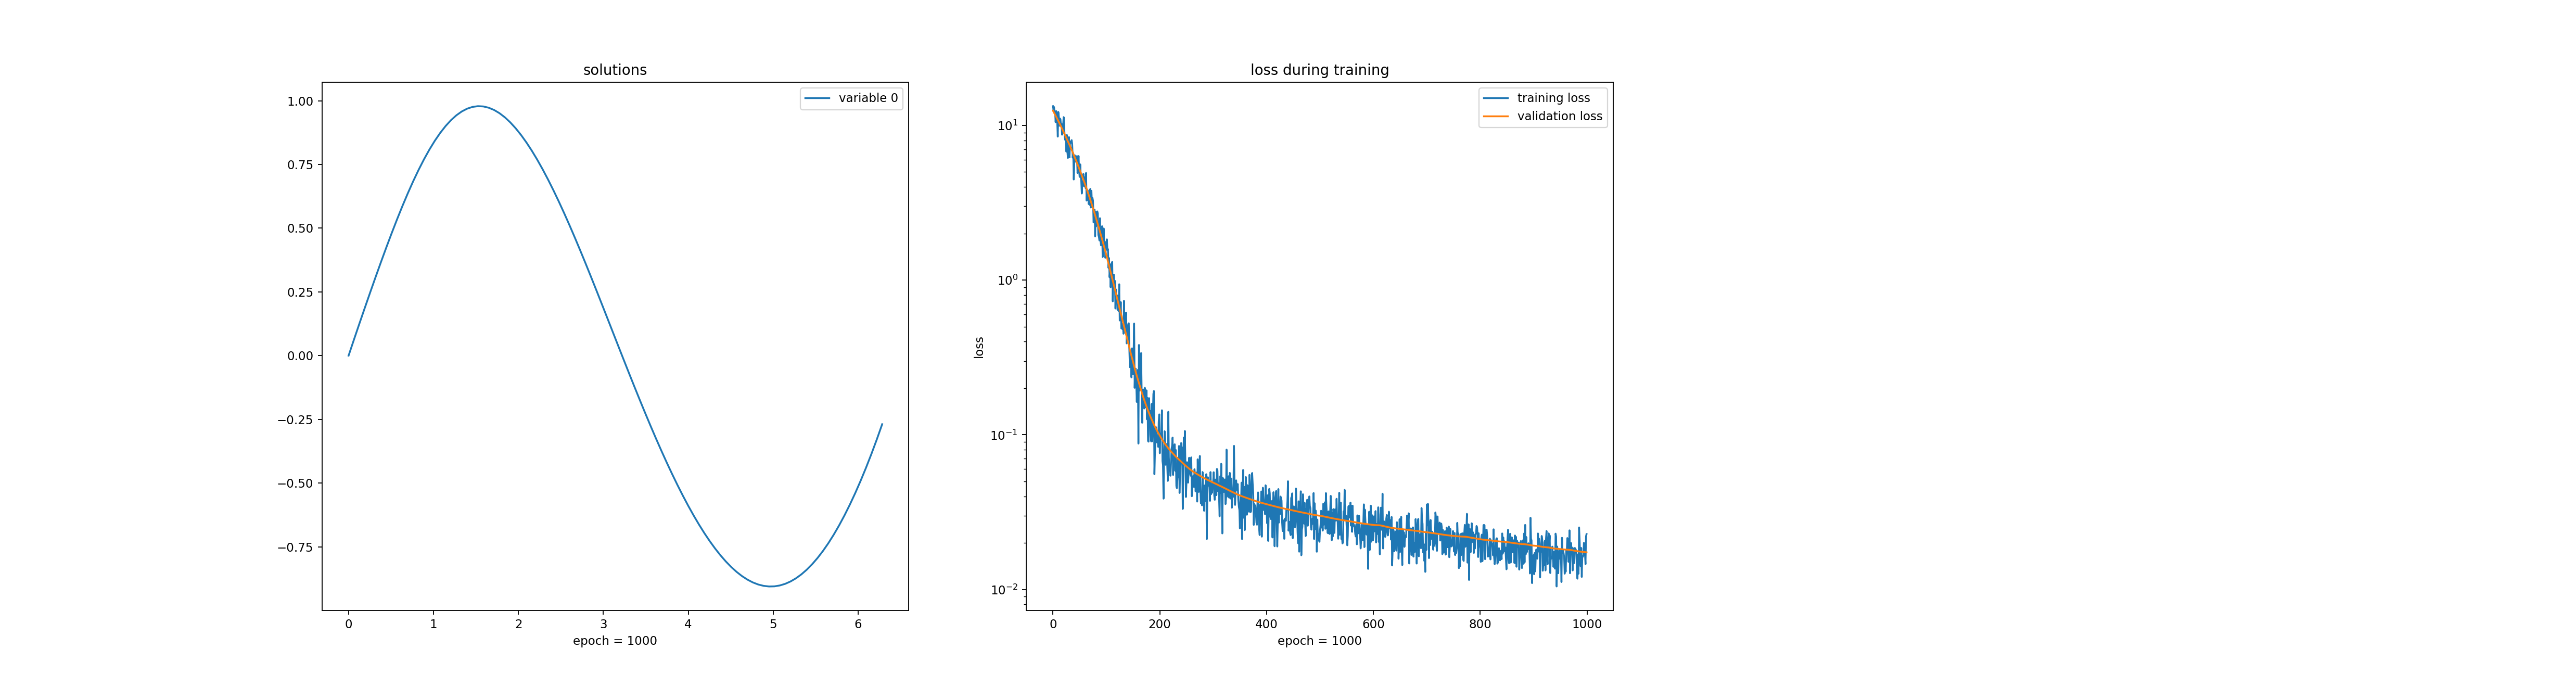

In [16]:
# specify the neural network architecture
nets_single = [FCNN(n_input_units=1, n_output_units=1, hidden_units=[64], actv=SinActv)]

solver1 = Solver1D(
    ode_system=harmonic_oscillator, 
    conditions=init_val_ho, 
    t_min=0.0, t_max=2*np.pi, 
    nets=nets_single,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)


# Fit the solver (i.e., train the neural networks)
solver1.fit(
    max_epochs=1000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

# Get the solution
solution_ho1 = solver1.get_solution()

Use 10 hidden layers

<IPython.core.display.Javascript object>


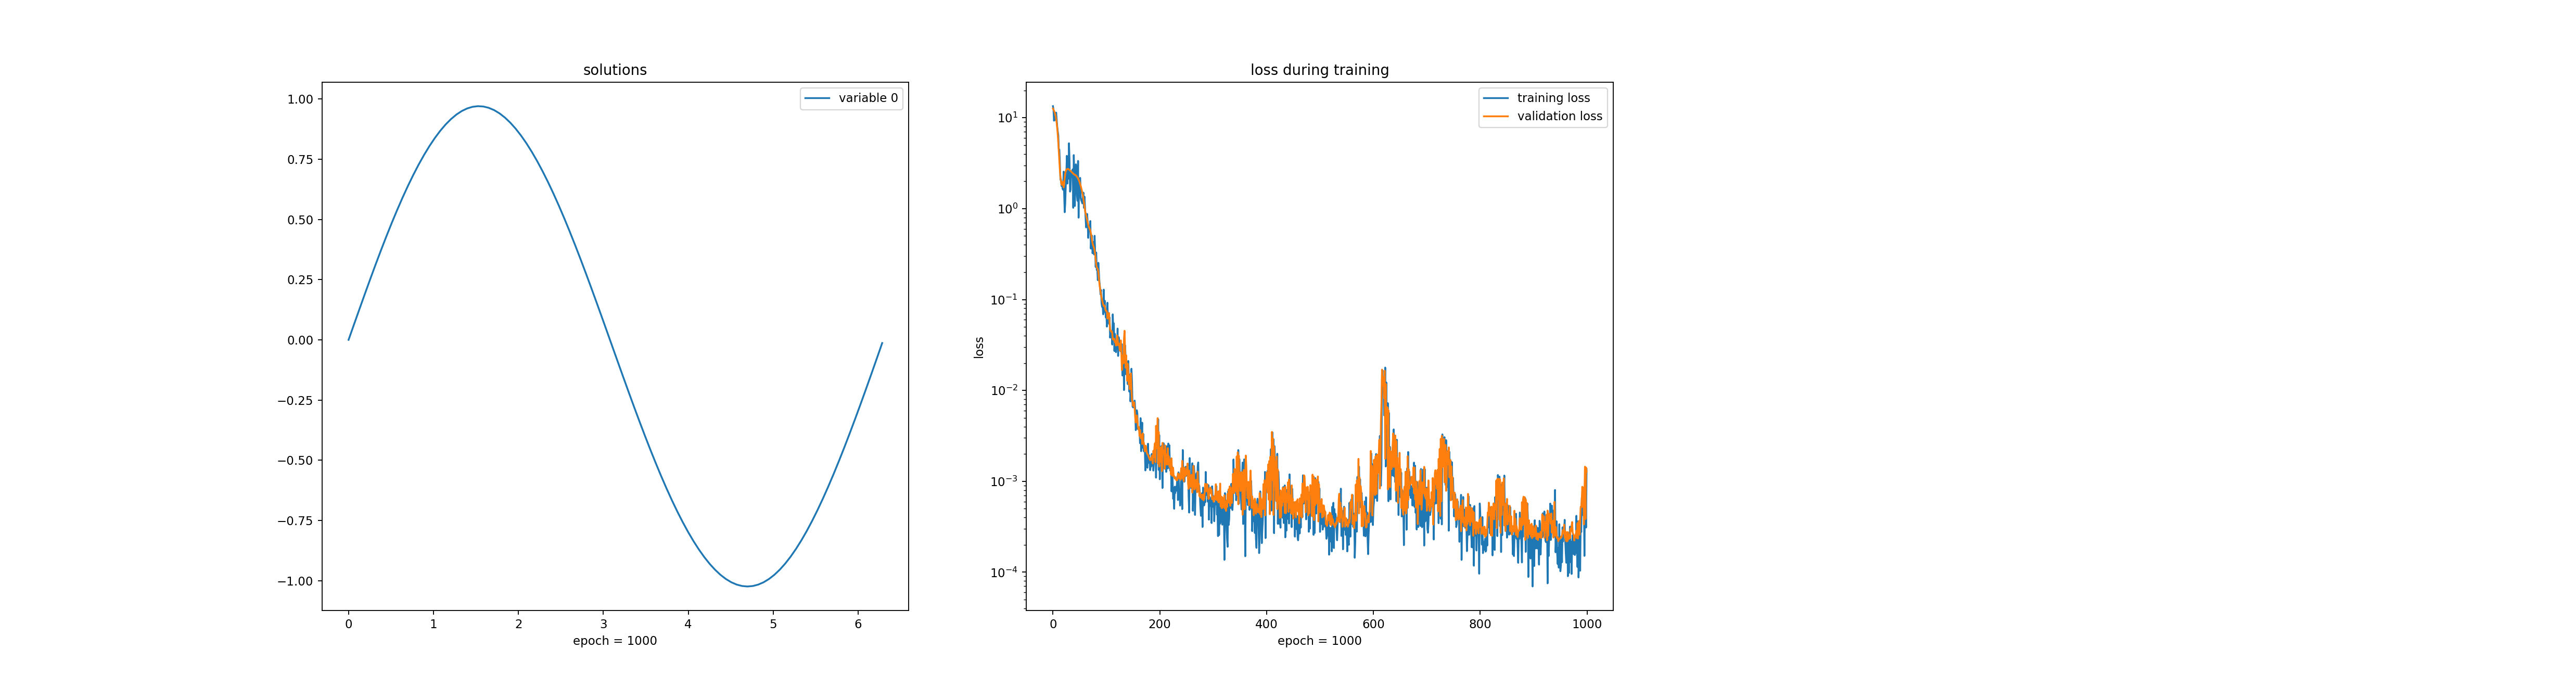

In [17]:
# specify the neural network architecture
nets_ten = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(64,64,64,64,64,64,64,64,64,64), actv=SinActv)]

solver1 = Solver1D(
    ode_system=harmonic_oscillator, 
    conditions=init_val_ho, 
    t_min=0.0, t_max=2*np.pi, 
    nets=nets_ten,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)


# Fit the solver (i.e., train the neural networks)
solver1.fit(
    max_epochs=1000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

# Get the solution
solution_ho1 = solver1.get_solution()

## Fine-tune of the activation functions

### SinActv v.s. Sigmoid
We may want to check whether the choice of activation function will lead to convergence speed difference.

<IPython.core.display.Javascript object>


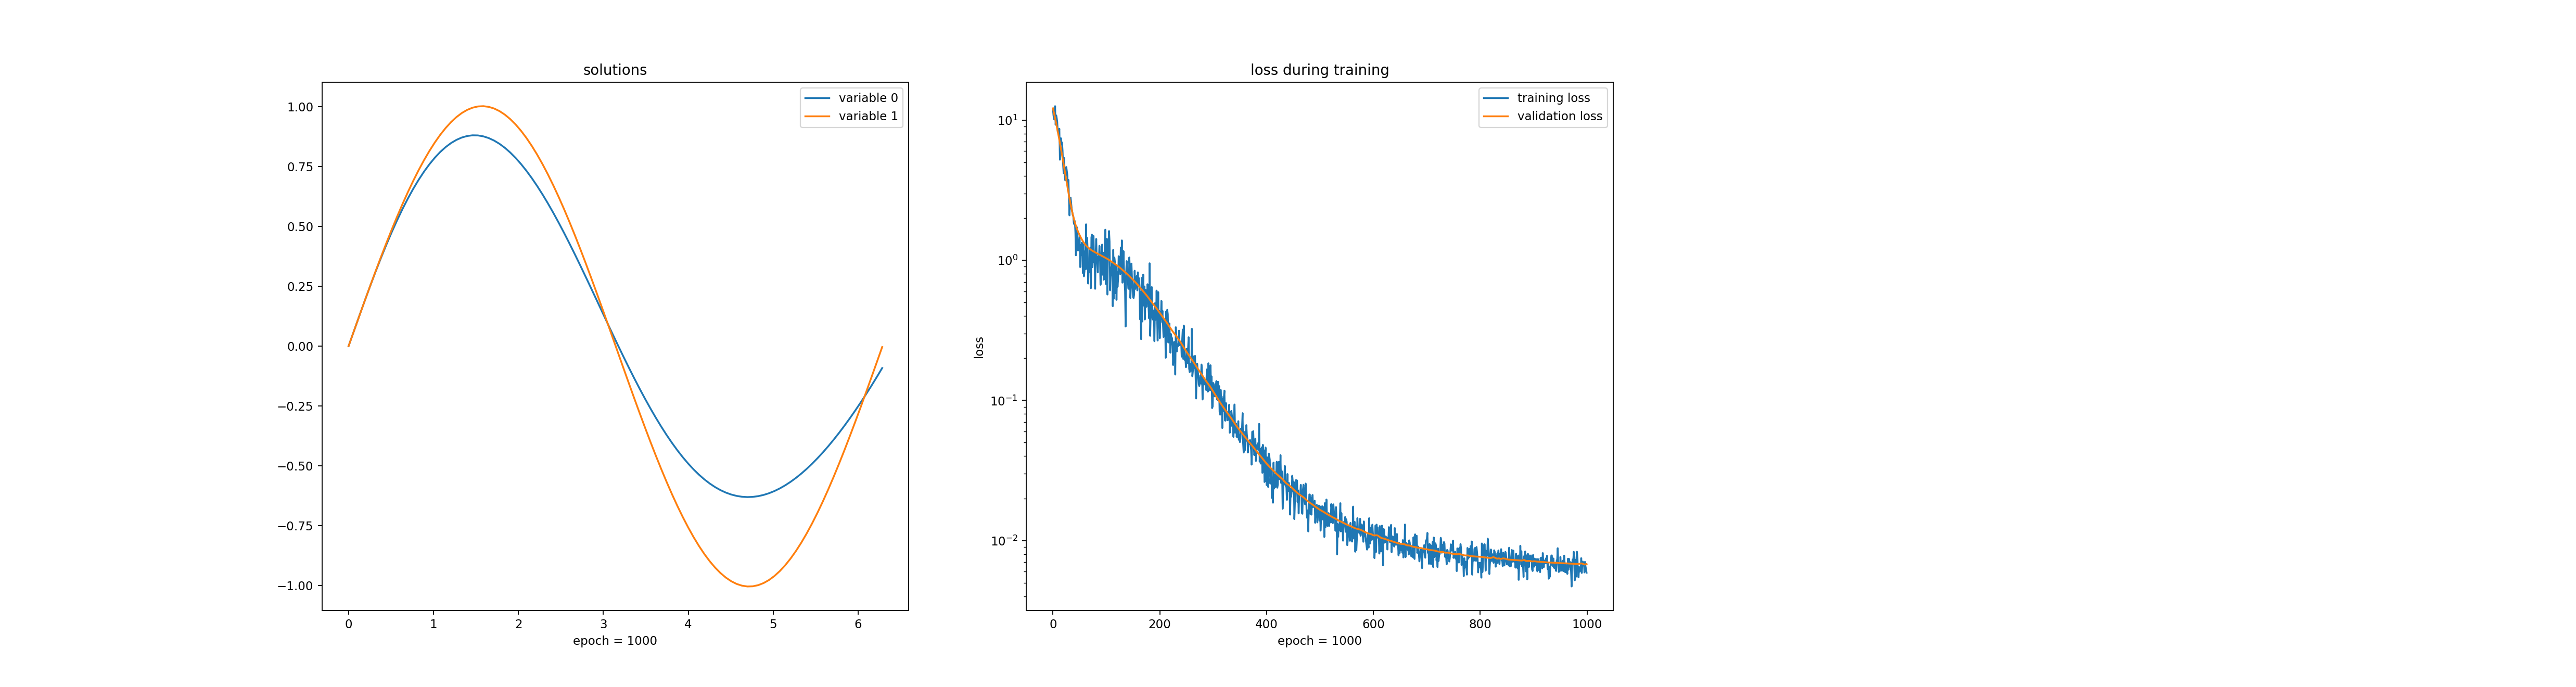

In [19]:
# To make the comparison more intuitive, we write two same differential equations into a ODE system
harmonic_oscillator_compare = lambda u,v, t: [diff(u, t, order=2) + u,
                                      diff(v, t, order=2) + v,]

init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0),
              IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0),]

# Compare the activation function SinActv and Sigmond in our neural network architecture
# We construct two independent neural networks with the same configurations except their activation functions

nets_act = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64), actv=torch.nn.Sigmoid),
           FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64), actv=SinActv),]

solver_ho_compare = Solver1D(
    ode_system=harmonic_oscillator_compare, 
    conditions=init_val_ho, 
    t_min=0.0, t_max=2*np.pi, 
    nets=nets_act,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)


# Fit the solver (i.e., train the neural networks)
solver_ho_compare.fit(
    max_epochs=1000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

# Get the solution
solution_ho_compare = solver_ho_compare.get_solution()

Now, to give a intuitive comparison, we put these two pics into one panel.

Through the loss diagram, we can tell that the gradient descent steadily under `SinActv`. So will it still perform better than `Sigmoid` if we increase the epochs?

<IPython.core.display.Javascript object>


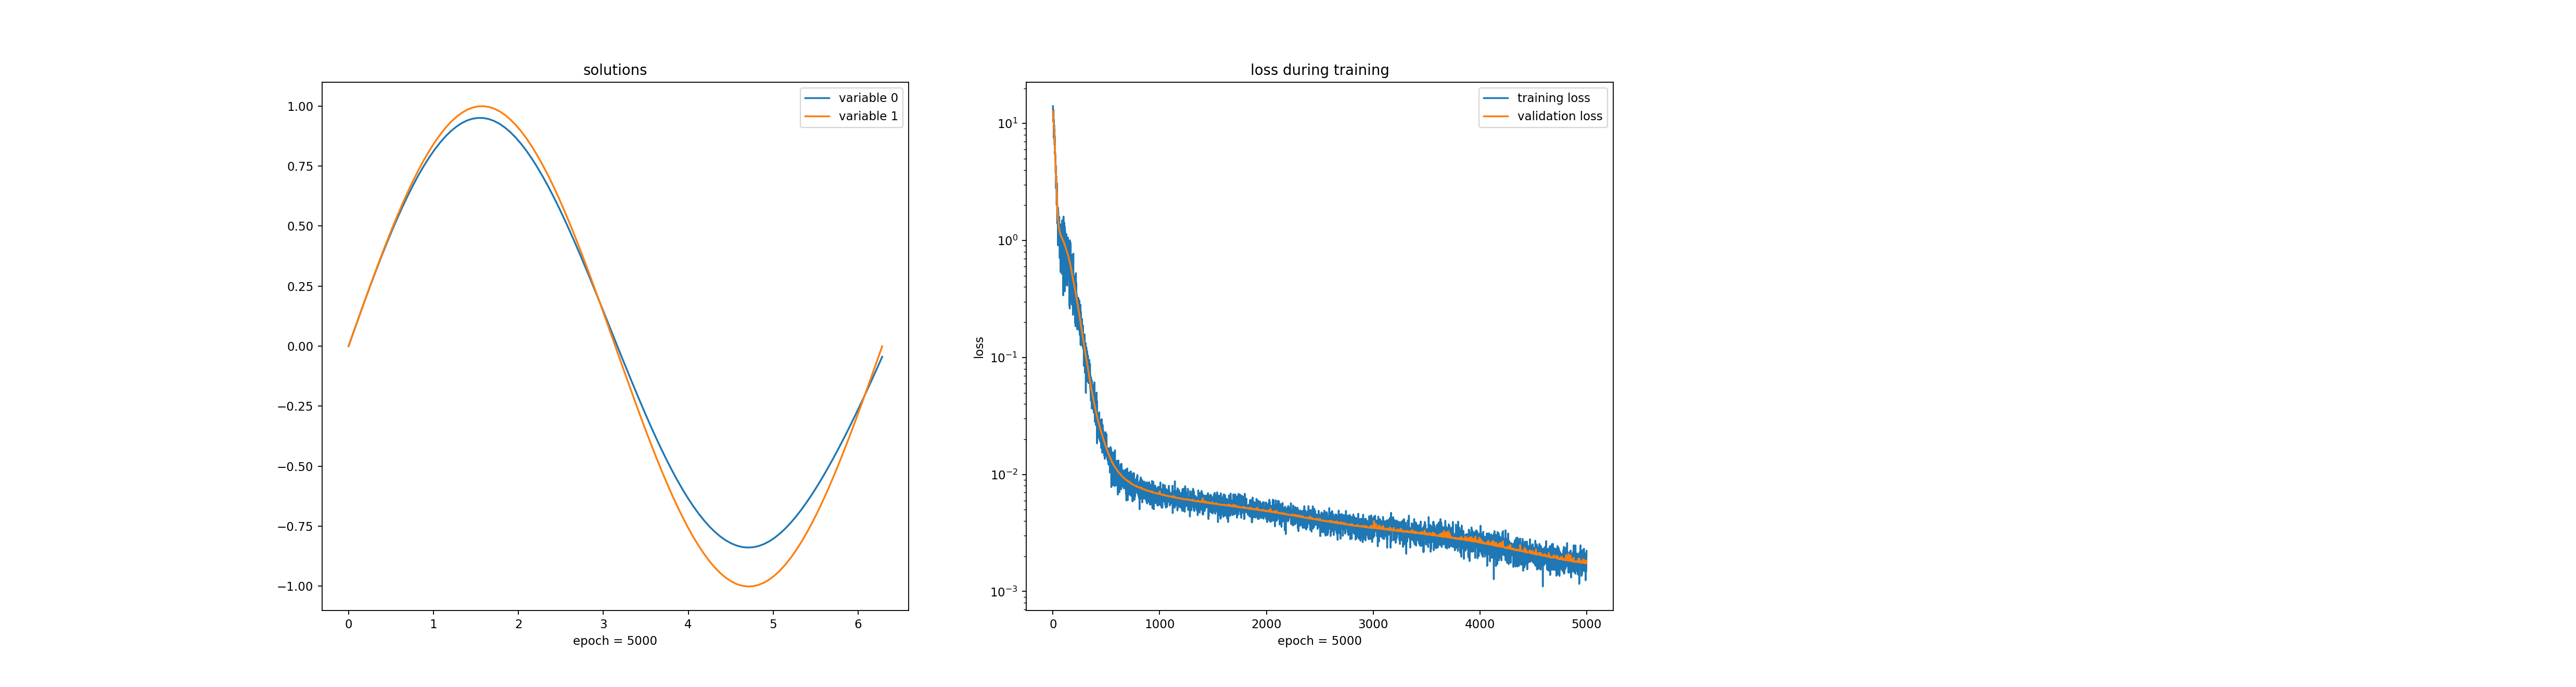

In [21]:
# To make the comparison more intuitive, we write two same differential equations into a ODE system
harmonic_oscillator_compare = lambda u,v, t: [diff(u, t, order=2) + u,
                                      diff(v, t, order=2) + v,]

init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0),
              IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0),]

# Compare the activation function SinActv and Sigmond in our neural network architecture
# We construct two independent neural networks with the same configurations except their activation functions

nets_act = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64), actv=torch.nn.Sigmoid),
           FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64), actv=SinActv),]

solver_ho_compare = Solver1D(
    ode_system=harmonic_oscillator_compare, 
    conditions=init_val_ho, 
    t_min=0.0, t_max=2*np.pi, 
    nets=nets_act,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)


# Fit the solver (i.e., train the neural networks)
solver_ho_compare.fit(
    max_epochs=5000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

# Get the solution
solution_ho_compare = solver_ho_compare.get_solution()

From the second experiment with epochs = 3000, we can tell that the loss function of `SinAct` decrease steadily. However, it maybe a risky choice to use `Sigmoid` here, because its randomness is unpredictable. 

### SinActv v.s. Tanh

<IPython.core.display.Javascript object>


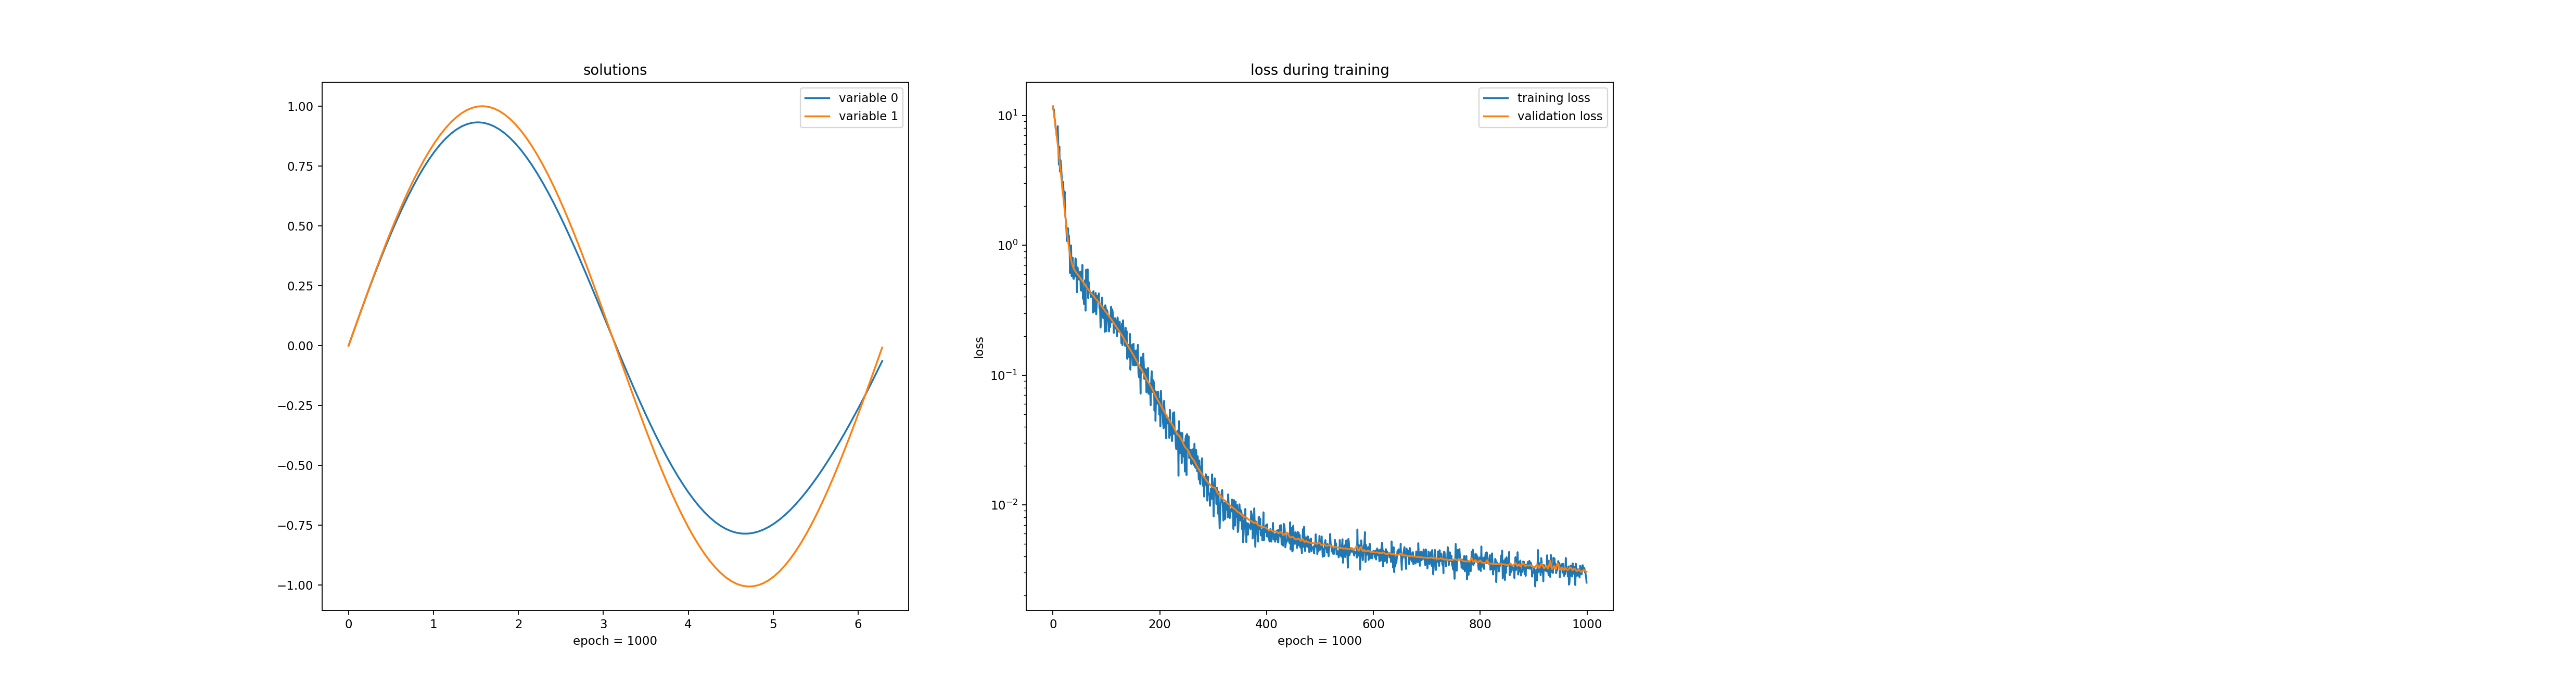

In [22]:
# To make the comparison more intuitive, we write two same differential equations into a ODE system
harmonic_oscillator_compare = lambda u,v, t: [diff(u, t, order=2) + u,
                                      diff(v, t, order=2) + v,]

init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0),
              IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0),]

# Compare the activation function SinActv and Sigmond in our neural network architecture
# We construct two independent neural networks with the same configurations except their activation functions

nets_act = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64)),
           FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64), actv=SinActv),]

solver_ho_compare = Solver1D(
    ode_system=harmonic_oscillator_compare, 
    conditions=init_val_ho, 
    t_min=0.0, t_max=2*np.pi, 
    nets=nets_act,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)


# Fit the solver (i.e., train the neural networks)
solver_ho_compare.fit(
    max_epochs=1000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

# Get the solution
solution_ho_compare = solver_ho_compare.get_solution()

<IPython.core.display.Javascript object>


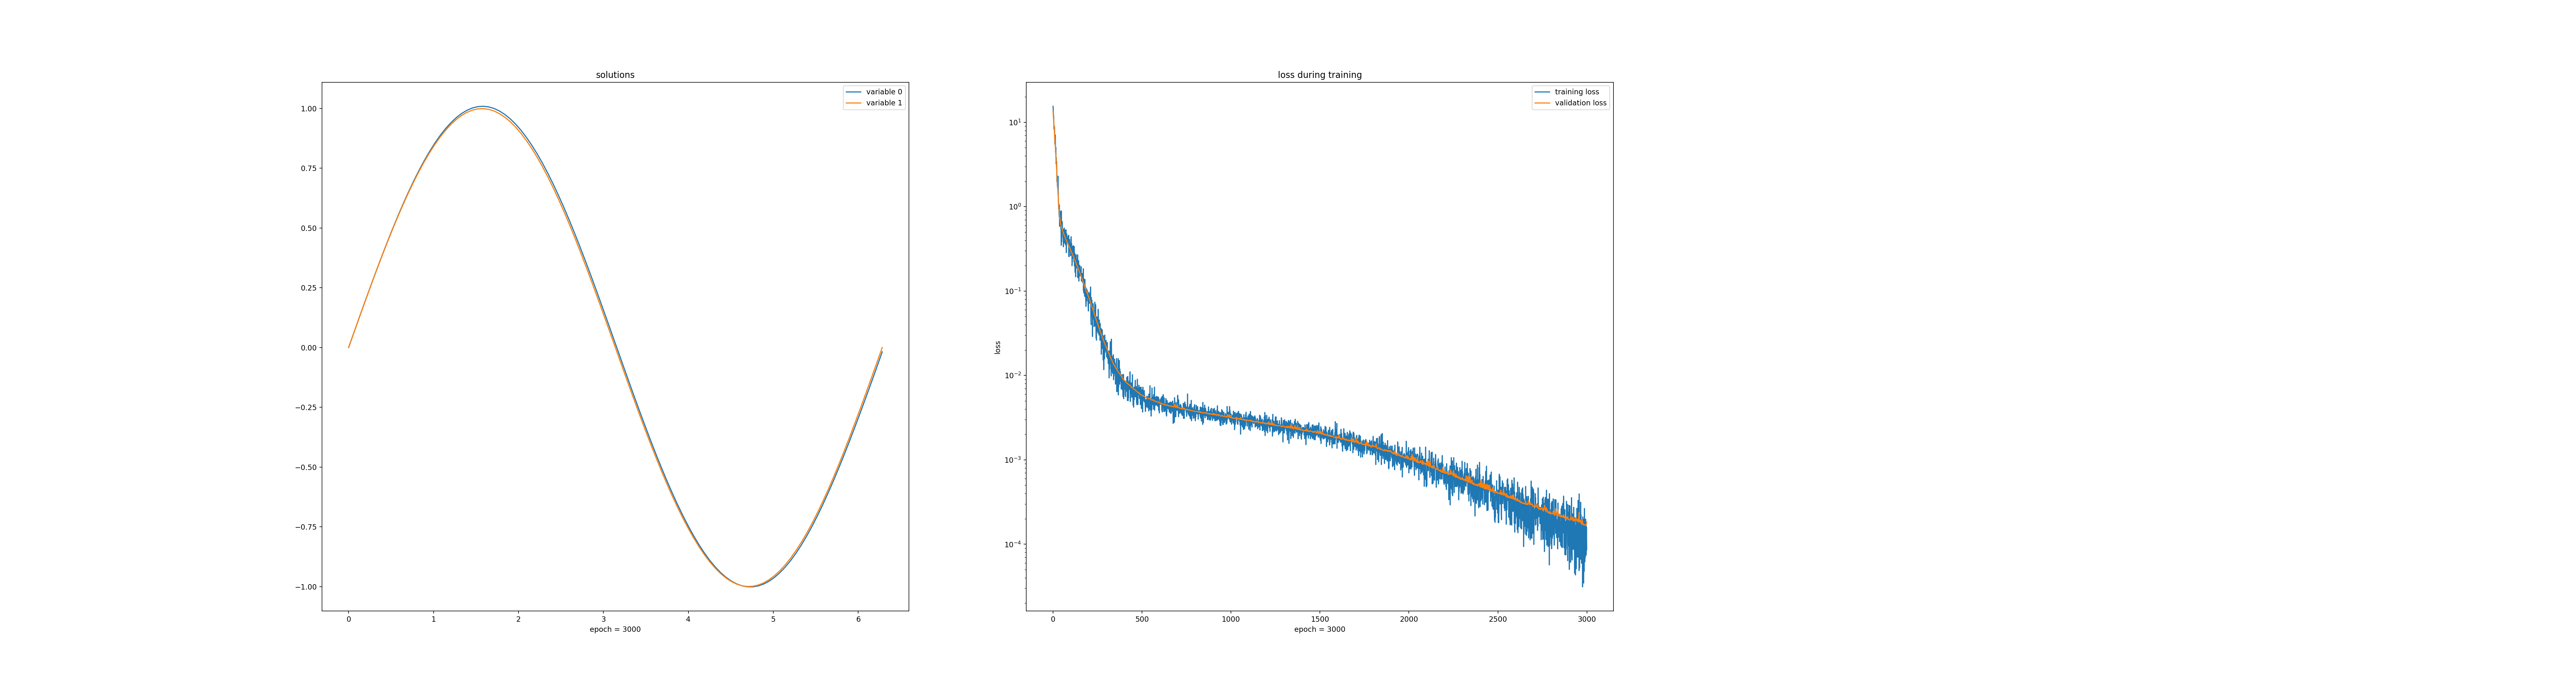

In [23]:
# To make the comparison more intuitive, we write two same differential equations into a ODE system
harmonic_oscillator_compare = lambda u,v, t: [diff(u, t, order=2) + u,
                                      diff(v, t, order=2) + v,]

init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0),
              IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0),]

# Compare the activation function SinActv and Sigmond in our neural network architecture
# We construct two independent neural networks with the same configurations except their activation functions

nets_act = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64)),
           FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64), actv=SinActv),]

solver_ho_compare = Solver1D(
    ode_system=harmonic_oscillator_compare, 
    conditions=init_val_ho, 
    t_min=0.0, t_max=2*np.pi, 
    nets=nets_act,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)


# Fit the solver (i.e., train the neural networks)
solver_ho_compare.fit(
    max_epochs=3000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

# Get the solution
solution_ho_compare = solver_ho_compare.get_solution()